In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
!pip install kneed
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

In [33]:
df = pd.read_csv ('https://raw.githubusercontent.com/CarrenP/files/refs/heads/main/COVID-19%20Coronavirus.csv')
df.head()

,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


### **Data Cleaning**

In [34]:
df.drop(['Country','Other names', 'ISO 3166-1 alpha-3 CODE'], axis=1, inplace=True)
df.head()

,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,40462186,Asia,177827,7671,4395,190,4.313743
1,2872296,Europe,273870,3492,95349,1216,1.275058
2,45236699,Africa,265691,6874,5873,152,2.587216
3,77481,Europe,40024,153,516565,1975,0.382271
4,34654212,Africa,99194,1900,2862,55,1.915438


In [35]:
# df.columns.values[4] = "TotalCasesPer1MPopulation"
# df.columns.values[5] = "TotalDeathsPer1MPopulation"

df.rename(columns={df.columns[4]: 'TotalCasesPer1MPopulation'}, inplace=True)
df.rename(columns={df.columns[5]: 'TotalDeathsPer1MPopulation'}, inplace=True)
df.head()

,Population,Continent,Total Cases,Total Deaths,TotalCasesPer1MPopulation,TotalDeathsPer1MPopulation,Death percentage
0,40462186,Asia,177827,7671,4395,190,4.313743
1,2872296,Europe,273870,3492,95349,1216,1.275058
2,45236699,Africa,265691,6874,5873,152,2.587216
3,77481,Europe,40024,153,516565,1975,0.382271
4,34654212,Africa,99194,1900,2862,55,1.915438


In [36]:
df.isnull().sum()

,0
Population,0
Continent,0
Total Cases,0
Total Deaths,0
TotalCasesPer1MPopulation,0
TotalDeathsPer1MPopulation,0
Death percentage,0


In [37]:
df.duplicated().value_counts()

,count
False,225


### **Data Preparation - Transformation**

In [38]:

label_encoder = LabelEncoder()
df['Continent'] = label_encoder.fit_transform(df['Continent'])
df.head()

,Population,Continent,Total Cases,Total Deaths,TotalCasesPer1MPopulation,TotalDeathsPer1MPopulation,Death percentage
0,40462186,1,177827,7671,4395,190,4.313743
1,2872296,2,273870,3492,95349,1216,1.275058
2,45236699,0,265691,6874,5873,152,2.587216
3,77481,2,40024,153,516565,1975,0.382271
4,34654212,0,99194,1900,2862,55,1.915438


In [39]:
sc = MinMaxScaler()
df_scale= pd.DataFrame(sc.fit_transform(df), columns=['Population', 'Continent','Total Cases', 'Total Deaths','TotalCasesPer1MPopulation', 'TotalDeathsPer1MPopulation', 'Death percentage'])
df_scale.head()

,Population,Continent,Total Cases,Total Deaths,TotalCasesPer1MPopulation,TotalDeathsPer1MPopulation,Death percentage
0,0.028111,0.2,0.002173,0.007608,0.006301,0.030226,0.237648
1,0.001995,0.4,0.003346,0.003464,0.136976,0.193446,0.070244
2,0.031429,0.0,0.003246,0.006818,0.008425,0.024181,0.142532
3,0.000053,0.4,0.000489,0.000152,0.742141,0.314190,0.021060
4,0.024076,0.0,0.001212,0.001885,0.004099,0.008750,0.105523


# **EDA**

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Population                  225 non-null    int64  
 1   Continent                   225 non-null    int64  
 2   Total Cases                 225 non-null    int64  
 3   Total Deaths                225 non-null    int64  
 4   TotalCasesPer1MPopulation   225 non-null    int64  
 5   TotalDeathsPer1MPopulation  225 non-null    int64  
 6   Death percentage            225 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 12.4 KB


In [41]:
df.describe()

,Population,Continent,Total Cases,Total Deaths,TotalCasesPer1MPopulation,TotalDeathsPer1MPopulation,Death percentage
count,2.250000e+02,225.000000,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000
mean,3.507321e+07,1.751111,2.184781e+06,2.744813e+04,136900.373333,1096.715556,1.444125
std,1.392418e+08,1.476093,7.275938e+06,9.689177e+04,145060.340289,1195.715543,1.741728
min,8.050000e+02,0.000000,1.000000e+00,0.000000e+00,9.000000,0.000000,0.000000
25%,5.665570e+05,0.000000,2.407100e+04,1.890000e+02,11384.000000,123.000000,0.511291
50%,5.827911e+06,2.000000,1.639360e+05,1.965000e+03,88987.000000,708.000000,1.036905
75%,2.190585e+07,3.000000,1.092547e+06,1.366000e+04,223335.000000,1795.000000,1.977017
max,1.439324e+09,5.000000,8.183905e+07,1.008222e+06,696044.000000,6286.000000,18.151787


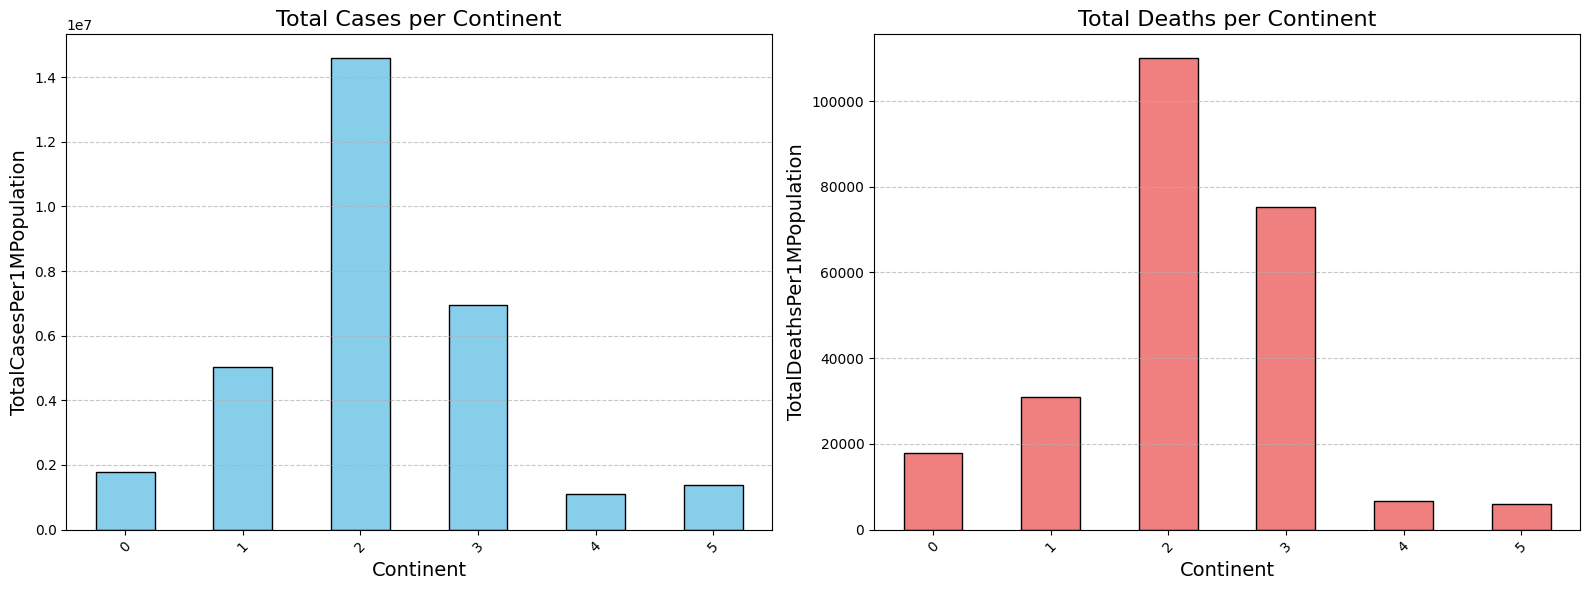

In [42]:
import matplotlib.pyplot as plt

# Mengelompokkan data berdasarkan Continent
grouped_cases = df.groupby("Continent")["TotalCasesPer1MPopulation"].sum()
grouped_deaths = df.groupby("Continent")["TotalDeathsPer1MPopulation"].sum()

# Membuat figure dengan 2 subplot berdampingan
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 baris, 2 kolom

# Grafik Total Cases per Continent
grouped_cases.plot(kind="bar", color="skyblue", edgecolor="black", ax=axes[0])
axes[0].set_title("Total Cases per Continent", fontsize=16)
axes[0].set_xlabel("Continent", fontsize=14)
axes[0].set_ylabel("TotalCasesPer1MPopulation", fontsize=14)
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Grafik Total Deaths per Continent
grouped_deaths.plot(kind="bar", color="lightcoral", edgecolor="black", ax=axes[1])
axes[1].set_title("Total Deaths per Continent", fontsize=16)
axes[1].set_xlabel("Continent", fontsize=14)
axes[1].set_ylabel("TotalDeathsPer1MPopulation", fontsize=14)
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Menyesuaikan tata letak
plt.tight_layout()
plt.show()


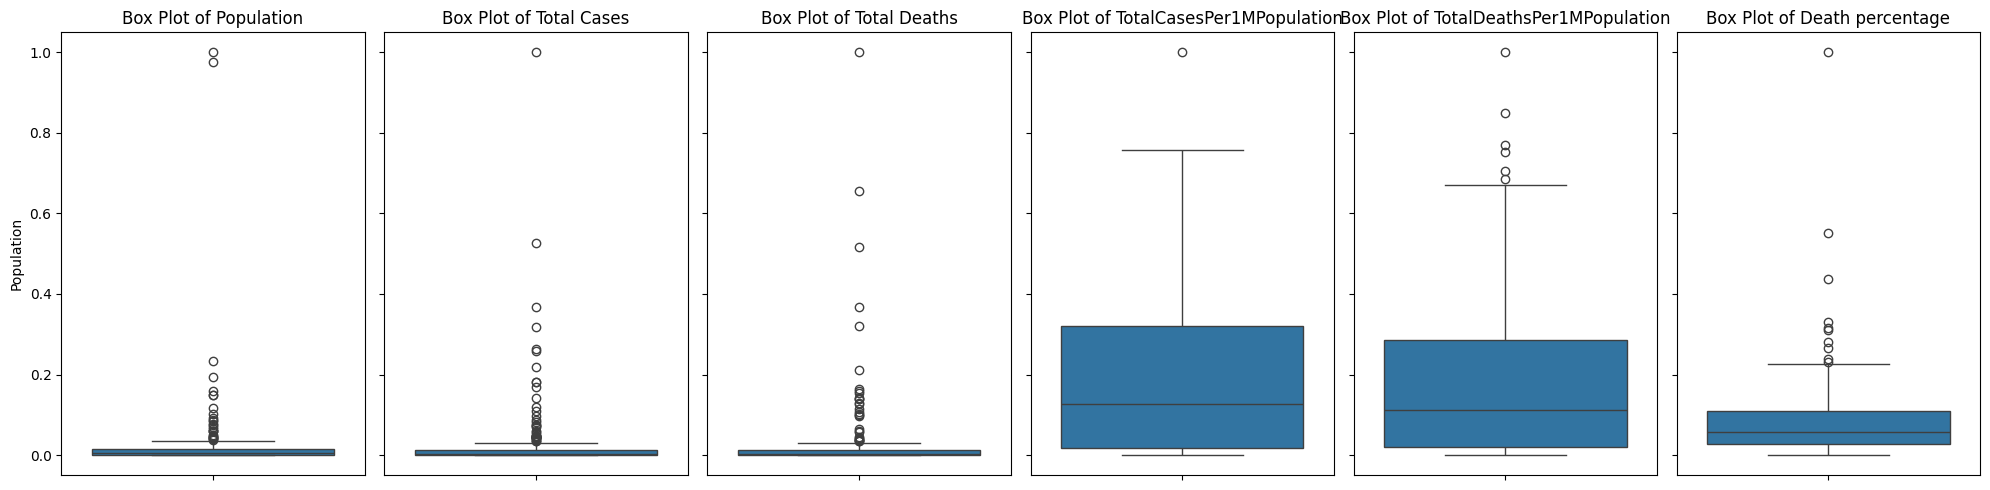

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# List kolom numerik yang ingin di-plot
numeric_cols = ['Population', 'Total Cases', 'Total Deaths', 'TotalCasesPer1MPopulation', 'TotalDeathsPer1MPopulation', 'Death percentage']

# Tentukan ukuran figure dan jumlah subplot
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(20, 5), sharey=True)

# Loop untuk membuat box plot pada setiap subplot
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df_scale[col], ax=axes[i])  # Plot box plot pada subplot ke-i
    axes[i].set_title(f'Box Plot of {col}')  # Atur judul pada subplot
    axes[i].set_ylabel(col)  # Atur label sumbu y untuk setiap subplot

plt.tight_layout()  # Atur tata letak agar tidak saling tumpang tindih
plt.show()  # Tampilkan plot

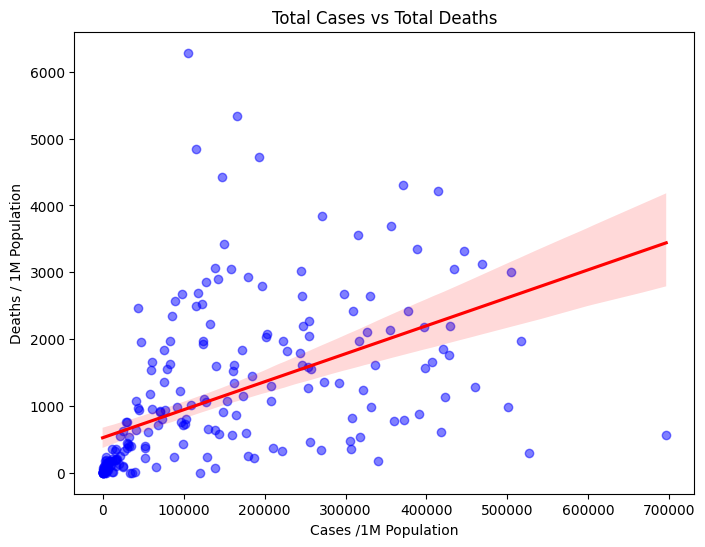

In [44]:


# Visualize the position
plt.figure(figsize=(8, 6))

# Menggunakan seaborn.regplot untuk scatter plot dengan garis regresi
# scatter_kws={'alpha':0.5} membuat titik-titik scatter plot lebih transparan
# line_kws={'color': 'red'} membuat garis regresi berwarna merah
sns.regplot(x=df['TotalCasesPer1MPopulation'], y=df['TotalDeathsPer1MPopulation'], scatter_kws={'alpha':0.5, 'color':'blue'}, line_kws={'color': 'red'})

plt.title('Total Cases vs Total Deaths')
plt.xlabel('Cases /1M Population')
plt.ylabel('Deaths / 1M Population')
plt.show()

# **K-Means Clustering**

In [45]:
# set the parameter for evaluating K

# set the parameter for evaluating K
sse = []
# check the inertia for each K
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, random_state=42)
    kmeans.fit(df_scale)
    sse.append(kmeans.inertia_)

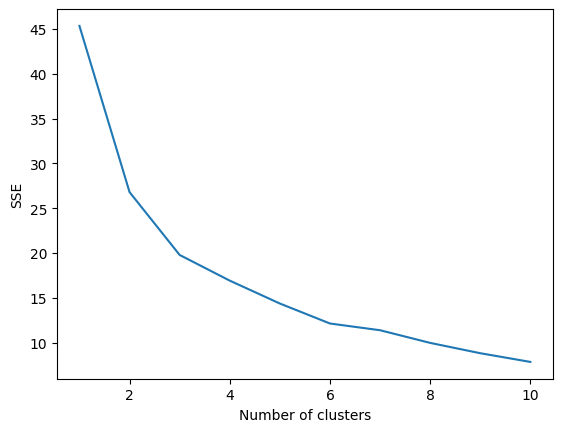

In [46]:
# manually visualize the elbow method using plotlib
plt.plot(range(1, 11), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [47]:

# using kneelocator to find the elbow/knee
kneedle = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("The best k for your model is", kneedle.elbow)

The best k for your model is 3


In [48]:

kmeans = KMeans(n_clusters=3, init='random', max_iter=300, random_state=42)
y_pred = kmeans.fit_predict(df_scale)
y_pred

array([0, 1, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1, 2, 0, 1, 1, 2, 1, 0, 1,
       0, 1, 2, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 2, 0, 1,
       0, 0, 1, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0,
       2, 1, 1, 1, 2, 1, 1, 0, 0, 2, 2, 0, 2, 2, 1, 1, 2, 1, 0, 0, 1, 1,
       1, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 0, 0, 1, 1,
       2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 1,
       0, 1, 1, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0,
       0, 0, 2, 2, 0, 0, 1, 2, 2, 1, 0, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0], dtype=int32)

<ipython-input-49-34d7ee946163>:4: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(x="TotalCasesPer1MPopulation", y="TotalDeathsPer1MPopulation", hue=y_pred, palette=[


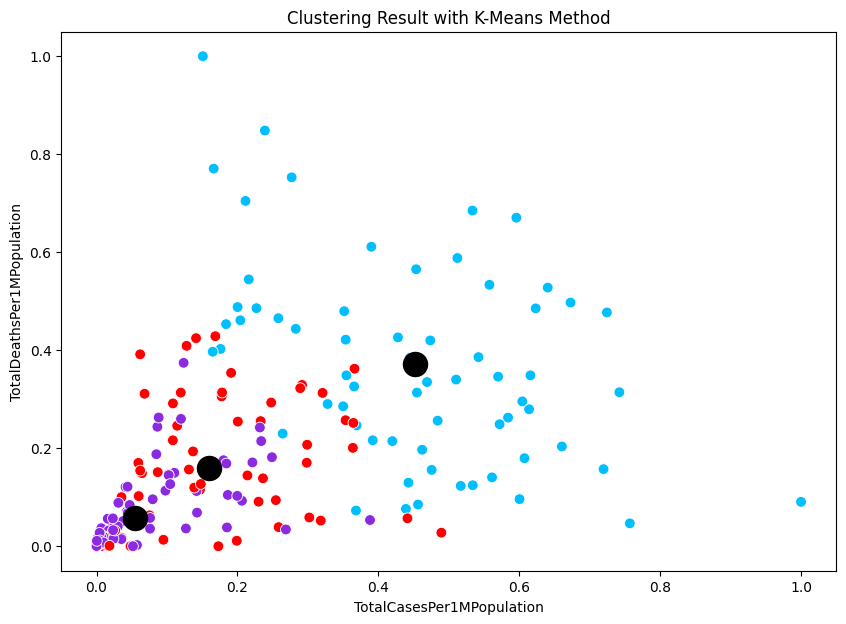

In [49]:
# visualize the result using scater chart
plt.figure(figsize=(10,7))

sns.scatterplot(x="TotalCasesPer1MPopulation", y="TotalDeathsPer1MPopulation", hue=y_pred, palette=[
    "blueviolet",
    "red",
    "deepskyblue",
    "orange",
    "springgreen"
], legend=None, data=df_scale, s=60)

plt.scatter(kmeans.cluster_centers_[:, 4], kmeans.cluster_centers_[:, 5], s=300, c="black")
plt.xlabel("TotalCasesPer1MPopulation")
plt.ylabel("TotalDeathsPer1MPopulation")
plt.title("Clustering Result with K-Means Method")
plt.show()

In [50]:
# Inverse transform the scaled data to get the original values
df_inverse = pd.DataFrame(sc.inverse_transform(df_scale), columns=['Population', 'Continent','Total Cases', 'Total Deaths','TotalCasesPer1MPopulation', 'TotalDeathsPer1MPopulation', 'Death percentage'])
# Add the cluster labels to the original data
df_inverse['Cluster'] = y_pred
# Analyze the clusters with the original values
df_inverse.head()

,Population,Continent,Total Cases,Total Deaths,TotalCasesPer1MPopulation,TotalDeathsPer1MPopulation,Death percentage,Cluster
0,40462186.0,1.0,177827.0,7671.0,4395.0,190.0,4.313743,0
1,2872296.0,2.0,273870.0,3492.0,95349.0,1216.0,1.275058,1
2,45236699.0,0.0,265691.0,6874.0,5873.0,152.0,2.587216,0
3,77481.0,2.0,40024.0,153.0,516565.0,1975.0,0.382271,2
4,34654212.0,0.0,99194.0,1900.0,2862.0,55.0,1.915438,0


In [51]:
# Group the data by cluster and calculate the mean spending and annual income for each cluster
cluster_summary = df_inverse.groupby(y_pred).agg({
    'TotalCasesPer1MPopulation': ['mean', 'std', 'min', 'max'],
    'TotalDeathsPer1MPopulation': ['mean', 'std', 'min', 'max'],
    'Death percentage': ['mean', 'std', 'min', 'max'],
    'Population': ['mean', 'std', 'min', 'max'],
    'Continent': [pd.Series.mode,'mean', 'std', 'min', 'max'],
    'Total Cases': ['mean', 'std', 'min', 'max'],
    'Total Deaths': ['mean', 'std', 'min', 'max']
})
cluster_summary = cluster_summary.T

# Ubah nama klaster menjadi 'Cluster 0', 'Cluster 1', dll.
cluster_summary.columns = [f'Cluster {i}' for i in range(cluster_summary.shape[1])]

# Menambahkan nama 'KMeans' pada level pertama kolom
cluster_summary.columns.name = 'KMeans'

# Menampilkan hasil
cluster_summary

KMeans                              Cluster 0     Cluster 1     Cluster 2
TotalCasesPer1MPopulation  mean  3.822264e+04  1.110685e+05  3.145671e+05
                           std   5.387032e+04  8.522448e+04  1.234757e+05
                           min   1.600000e+01  9.000000e+00  1.050620e+05
                           max   2.702080e+05  3.407030e+05  6.960440e+05
TotalDeathsPer1MPopulation mean  3.577071e+02  1.000565e+03  2.333016e+03
                           std   4.633119e+02  8.216318e+02  1.294580e+03
                           min   0.000000e+00  0.000000e+00  2.930000e+02
                           max   2.353000e+03  2.694000e+03  6.286000e+03
Death percentage           mean  1.888826e+00  1.165164e+00  1.026471e+00
                           std   2.264256e+00  1.084372e+00  1.052616e+00
                           min   0.000000e+00  0.000000e+00  5.554639e-02
                           max   1.815179e+01  5.705041e+00  5.983499e+00
Population                 mean  6.105183e+07  7.134876e+06  2.195278e+07
                           std   2.024321e+08  1.875655e+07  5.335893e+07
                           min   8.050000e+02  1.645000e+03  9.930000e+03
                           max   1.439324e+09  1.313040e+08  3.344006e+08
Continent                  mode  0.000000e+00  3.000000e+00  2.000000e+00
                           mean  4.444444e-01  3.564516e+00  2.015625e+00
                           std   5.194625e-01  9.516331e-01  6.782842e-01
                           min   0.000000e+00  2.000000e+00  0.000000e+00
                           max   2.000000e+00  5.000000e+00  4.000000e+00
Total Cases                mean  1.464848e+06  5.085026e+05  4.922324e+06
                           std   4.917557e+06  1.251714e+06  1.174315e+07
                           min   2.000000e+00  1.000000e+00  4.150000e+03
                           max   4.302904e+07  6.085926e+06  8.183905e+07
Total Deaths               mean  1.634516e+04  1.098285e+04  6.057377e+04
                           std   5.743244e+04  4.450691e+04  1.573385e+05
                           min   0.000000e+00  0.000000e+00  6.000000e+00
                           max   5.213880e+05  3.232120e+05  1.008222e+06

In [52]:
df_inverse['Cluster'].value_counts().sort_index()

,count
Cluster,
0,99
1,62
2,64


# **Hierarchical Clustering**

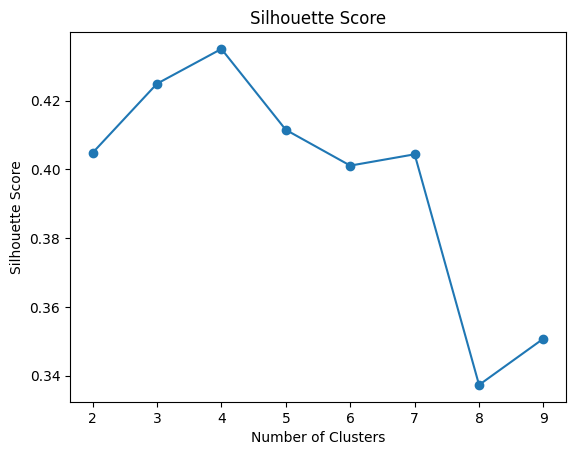

In [53]:
silhouette_scores = []

# The range was changed to start from 2, ensuring at least 2 clusters are formed.
for i in range(2, 10):
    cluster_labels = fcluster(linkage(df_scale, method='ward'), i, criterion='maxclust')
    silhouette_avg = silhouette_score(df_scale, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Score = the higher the better
plt.plot(range(2, 10), silhouette_scores, marker='o') # Adjusted x-axis range to match the loop
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

In [54]:
silhouette_scores = []
for k in range(2, 10):  # Mencoba jumlah cluster dari 2 hingga 9
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scale)  # X adalah dataset
    score = silhouette_score(df_scale, labels)
    silhouette_scores.append(score)
    print(f"Jumlah Cluster: {k}, Silhouette Score: {score}")

Jumlah Cluster: 2, Silhouette Score: 0.4196211008378522
Jumlah Cluster: 3, Silhouette Score: 0.42904597710452436
Jumlah Cluster: 4, Silhouette Score: 0.4093824243044551
Jumlah Cluster: 5, Silhouette Score: 0.41382502728527193
Jumlah Cluster: 6, Silhouette Score: 0.42843636621847464
Jumlah Cluster: 7, Silhouette Score: 0.38452485626493915
Jumlah Cluster: 8, Silhouette Score: 0.34935356993841854
Jumlah Cluster: 9, Silhouette Score: 0.33563420614792955


In [55]:

# Add the cluster labels to the original data that you have been added with kmeans so you have a full dataframe include kmeans and agglo clustering
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(df_scale)

# Step 2: Add Agglomerative Clustering labels to the original DataFrame
df_inverse['agglo'] = agglo_labels

# show the df
df_inverse.head()

,Population,Continent,Total Cases,Total Deaths,TotalCasesPer1MPopulation,TotalDeathsPer1MPopulation,Death percentage,Cluster,agglo
0,40462186.0,1.0,177827.0,7671.0,4395.0,190.0,4.313743,0,1
1,2872296.0,2.0,273870.0,3492.0,95349.0,1216.0,1.275058,1,1
2,45236699.0,0.0,265691.0,6874.0,5873.0,152.0,2.587216,0,1
3,77481.0,2.0,40024.0,153.0,516565.0,1975.0,0.382271,2,0
4,34654212.0,0.0,99194.0,1900.0,2862.0,55.0,1.915438,0,1


In [56]:
# Function to calculate mode for each cluster
def mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan

# Repeat for Agglomerative Clustering
agglo_summary = df_inverse.groupby(agglo_labels).agg({
    'TotalCasesPer1MPopulation': ['mean', 'std', 'min', 'max'],
    'TotalDeathsPer1MPopulation': ['mean', 'std', 'min', 'max'],
    'Death percentage': ['mean', 'std', 'min', 'max'],
    'Population': ['mean', 'std', 'min', 'max'],
    'Continent': [pd.Series.mode,'mean', 'std', 'min', 'max'],
    'Total Cases': ['mean', 'std', 'min', 'max'],
    'Total Deaths': ['mean', 'std', 'min', 'max']
})
agglo_summary = agglo_summary.T
agglo_summary = agglo_summary.rename_axis(index={'agglo': agglo_summary.index.levels[0].name})
agglo_summary

0             1             2
TotalCasesPer1MPopulation  mean  2.985335e+05  3.879560e+04  9.752594e+04
                           std   1.296104e+05  5.063439e+04  7.728609e+04
                           min   1.080000e+02  1.600000e+01  9.000000e+00
                           max   6.960440e+05  1.871130e+05  3.407030e+05
TotalDeathsPer1MPopulation mean  2.149110e+03  3.759192e+02  9.935849e+02
                           std   1.308394e+03  4.715873e+02  9.025698e+02
                           min   3.000000e+00  0.000000e+00  0.000000e+00
                           max   6.286000e+03  2.353000e+03  2.925000e+03
Death percentage           mean  1.056116e+00  1.868705e+00  1.185469e+00
                           std   1.163309e+00  2.262618e+00  9.608241e-01
                           min   5.554639e-02  0.000000e+00  0.000000e+00
                           max   5.983499e+00  1.815179e+01  4.119248e+00
Population                 mean  5.981271e+07  3.199575e+07  6.746508e+06
                           std   2.359562e+08  4.937243e+07  1.186481e+07
                           min   9.930000e+03  8.050000e+02  1.645000e+03
                           max   1.439324e+09  2.785865e+08  5.183223e+07
Continent                  mode  2.000000e+00  0.000000e+00  3.000000e+00
                           mean  2.054795e+00  4.747475e-01  3.716981e+00
                           std   7.243850e-01  5.775288e-01  9.277217e-01
                           min   0.000000e+00  0.000000e+00  3.000000e+00
                           max   4.000000e+00  2.000000e+00  5.000000e+00
Total Cases                mean  5.006173e+06  9.100076e+05  6.798949e+05
                           std   1.201341e+07  2.162064e+06  1.681905e+06
                           min   4.150000e+03  2.000000e+00  1.000000e+00
                           max   8.183905e+07  1.489473e+07  9.041124e+06
Total Deaths               mean  6.246096e+04  1.099418e+04  9.957642e+03
                           std   1.610136e+05  2.588035e+04  2.708317e+04
                           min   6.000000e+00  0.000000e+00  0.000000e+00
                           max   1.008222e+06  1.552880e+05  1.396600e+05

In [57]:
cluster_counts = df_inverse['agglo'].value_counts().sort_index()
cluster_counts

,count
agglo,
0,73
1,99
2,53


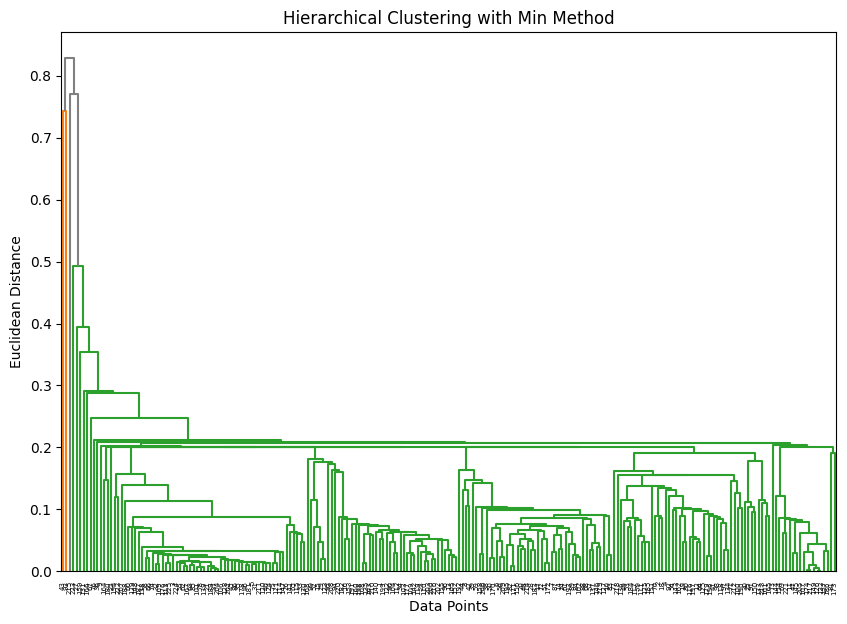

In [58]:
import scipy.cluster.hierarchy as sch
# Min Distance
# Buat linkage matrix
linked = linkage(df_scale, method='single')

# Tentukan jumlah cluster yang diinginkan
n_clusters = 3

# Gunakan fcluster untuk mendapatkan label cluster
cluster_labels = fcluster(linked, t=n_clusters, criterion='distance')

# Tentukan color_threshold agar sesuai dengan pemotongan
color_threshold = linked[-(n_clusters-1), 2]

# Plot dendrogram dengan color_threshold yang sesuai
plt.figure(figsize=(10, 7))
sch.dendrogram(linked,
           color_threshold=color_threshold,  # Menentukan ketinggian pemotongan sesuai jumlah cluster
           above_threshold_color='grey',     # Warna cabang di atas threshold
           labels=np.arange(1, df.shape[0] + 1))
plt.title("Hierarchical Clustering with Min Method")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

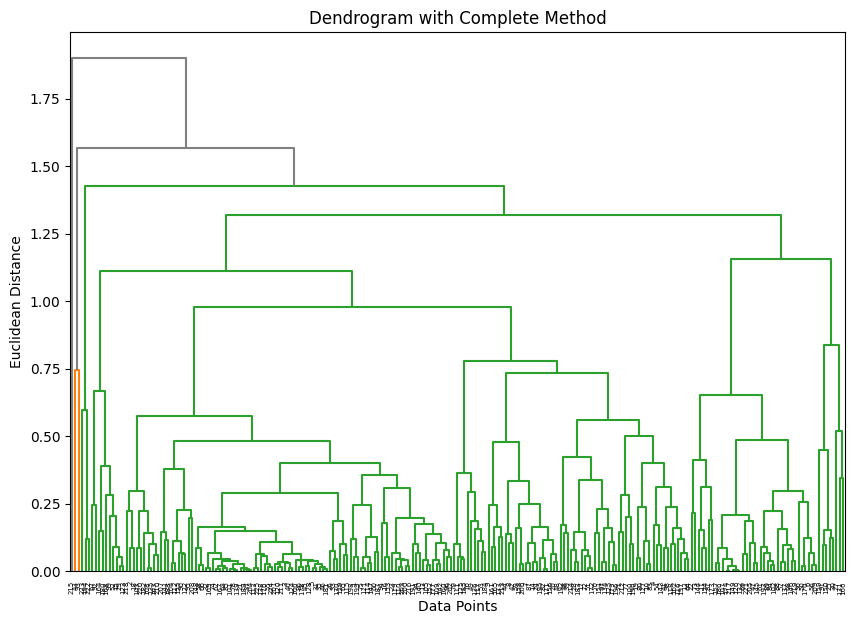

In [59]:
# Max Distance
n_clusters = 3
linked = linkage(df_scale, method='complete', metric='euclidean')
cluster_labels = fcluster(linked, t=n_clusters, criterion='distance')

color_threshold = linked[-(n_clusters-1), 2]

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked,
           color_threshold=color_threshold,
           above_threshold_color='grey',
           labels=np.arange(1, df.shape[0] + 1))
plt.title("Dendrogram with Complete Method")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

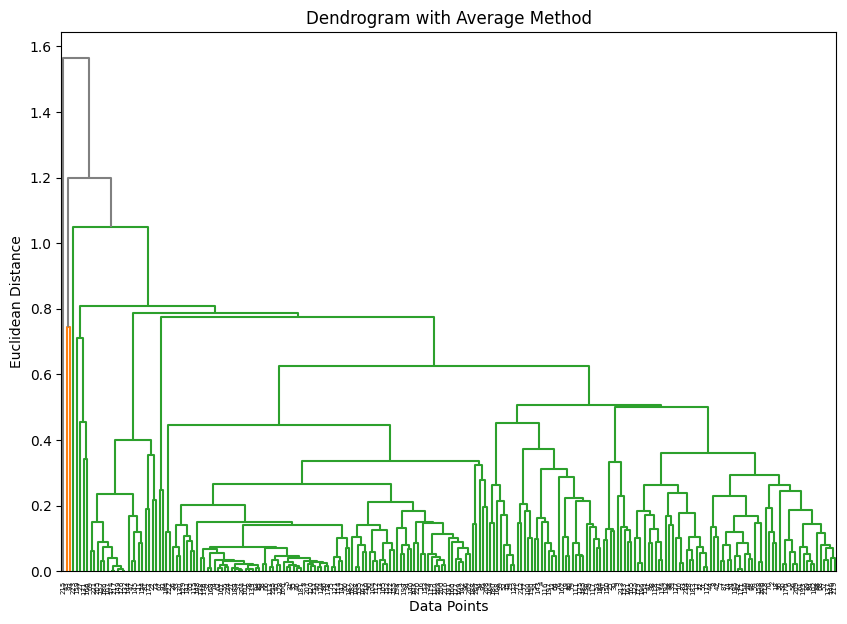

In [60]:
# Average Distance
n_clusters = 3
linked = linkage(df_scale, method='average', metric='euclidean')
cluster_labels = fcluster(linked, t=n_clusters, criterion='distance')

color_threshold = linked[-(n_clusters-1), 2]

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked,
           color_threshold=color_threshold,
           above_threshold_color='grey',
           labels=np.arange(1, df.shape[0] + 1))
plt.title("Dendrogram with Average Method")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

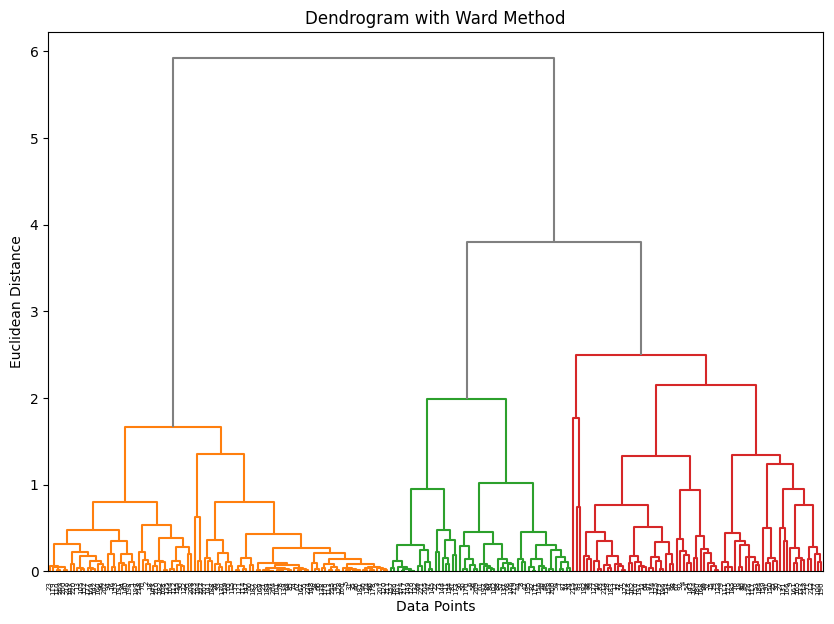

In [61]:
# Ward Method
n_clusters = 3
linked = linkage(df_scale, method='ward', metric='euclidean')
cluster_labels = fcluster(linked, t=n_clusters, criterion='distance')

color_threshold = linked[-(n_clusters-1), 2]

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked,
           color_threshold=color_threshold,
           above_threshold_color='grey',
           labels=np.arange(1, df.shape[0] + 1))
plt.title("Dendrogram with Ward Method")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

In [62]:

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scale)
kmeans_silhouette = silhouette_score(df_scale, kmeans_labels)
print(f"Silhouette Score K-Means Clustering: {kmeans_silhouette}")

# Hierarchical Clustering
linkage_methods = ['ward', 'single', 'complete', 'average']
silhouette_scores = {} # Menyimpan silhouette score untuk setiap metode

for method in linkage_methods:
    hc = AgglomerativeClustering(n_clusters=3, linkage=method)
    hc_labels = hc.fit_predict(df_scale)
    hc_silhouette = silhouette_score(df_scale, hc_labels)
    silhouette_scores[method] = hc_silhouette # Menyimpan skor
    print(f"Silhouette Score Hierarchical Clustering ({method}): {hc_silhouette}")


Silhouette Score K-Means Clustering: 0.42904597710452436
Silhouette Score Hierarchical Clustering (ward): 0.42494891780204064
Silhouette Score Hierarchical Clustering (single): 0.5416604662941845
Silhouette Score Hierarchical Clustering (complete): 0.5416604662941845
Silhouette Score Hierarchical Clustering (average): 0.5416604662941845
